# read in track files as useful dataframes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime, timedelta
import os
import pickle

## Helper methods

Previous plan: 
- make unique keys for every track (yyyymmdd-hh-lon-lat)
- figure out which MERRA2 tracks correspond to which ERA5 tracks (using condition of overlap for at least 24 hours with mean distance <5 degrees:
    - loop through the ERA 5 tracks
    - for a given ERA5 track, concatenate all the MERRA2 dfs together into one big df and use the appraoch in Suhas' script.
- use the ERA5 yyyymmdd to pick out the ECMWF and IITM files (they have filenames along the lines of LPS_track_yyyymmdd.txt), and then find which tracks inside those files are hits. 
- at this point, I will have 1 track for each of MERRA2, ERA5, ECMWF and IITM that correspond to the same system. I can then do the analysis.

Current update (07/2022):
- I only had 102 IITM track files (the hits that were common with the set of ECMWF hits, under the old matching criterion), because the rest of the files weren't regularly being accessed for a many months and got automatically deleted from Vishnu's scratch directory.
- Now, we are usinga different matching criterion, so need to check all the files.
- Vishnu only has the old candidate files, so we re-ran tempestextremes on those and are using the LPS_output files (can't get the LPS_track files because need MSLP data for that)
- currently, we won't worry about getting common hits

In [2]:
# "".join([str(int(x)).zfill(2) for x in list(group.iloc[0][2:5])]) outputs something of the form
#    yyyymmdd, e.g., '20070618'

def create_id(x):
    key = ("".join([str(int(elem)).zfill(2) for elem in list(x.iloc[0,2:5])]) # yyyymmdd
           +"-"
           +str(int(x.iloc[0,5])) # hh
           +"-"
           +"-".join([str(float(elem)) for elem in list(x.iloc[1][3:5])]) # lon-lat
          )
    return key

In [3]:
# There is 1 empty column at the start of all rows in LPS_track files (it is where
#    the 'start' in the 'start 41 2007 06 18 00' lines goes)

# param: csv: a text file (of the form LPS_track_yyyymmdd.txt) supplied by Vishnu
# param: column_names: a list of column names
# returns: a dictionary whose keys are dates of storms and values are dataframes
def read_vishnu_csv_to_dic(csv, column_names, data_name, keyIncludesHour=False, 
                           keyToCheckForHit=None, obsToCheckForHit=None,
                           lonMin=50, lonMax=100, latMin=0, latMax = 30, yearMin=2007, yearMax=2018,
                           monthMin=6, monthMax=9):
    
    file = csv
    df = pd.read_csv(file, header=None, names=column_names, sep='\t')
    
    # df[0] gets the first column, which is empty except for 'start'
    # .isin(['start'] returns a boolean array, where it is True wherever there is 'start' and False
    #    otherwise
    # .cumsum() returns an array of numbers, that starts at the first True and takes the value 1 at
    #    every index until the next True, after which it takes the value 2 until the next True, and
    #    so on.
    # so, the dataframe is grouped into the distinct storms, based on whenever there is a 'start' line.
    groups = df[0].isin(['start']).cumsum()
    
    # group.iloc[1:, 1:] gets rid of the first row (with 'start') and the first column (that is empty
    #    in all the rows except for in the 'start' row
    # so, in dic_of_dfs, the keys are the unique IDs based on genesis time and position
    #    (like '20070618-12-87.5-17.5') and the values are dataframes
    dic_of_dfs = {create_id(group): 
                  pd.concat([group.iloc[1:, 1:],
                             pd.Series(create_id(group),
                                       index=group.iloc[1:].index).rename(data_name+' key')], 
                            axis=1) 
                  for name, group in df.groupby(groups)
                  if (lonMin <= group.iloc[1, 3] <= lonMax
                      and latMin <= group.iloc[1, 4] <= latMax
                      and yearMin <= group.iloc[0, 2] <= yearMax
                      and monthMin <= group.iloc[0, 3] <= monthMax)}
        # the if condition filters for storms that are over India,
        #    and between 2007 and 2018,
        #    and in the Indian summer monsoon season (JJAS: June, July, August, September)
        # for 'over India', need longitude between 50 and 100 degrees, and latitude 
        #    between 5 and 30 degrees.
        
        # for reference:
        # group.iloc[1:]['Longitude'].between(lonMin, lonMax).all() 
        # and group.iloc[1:]['Latitude'].between(latMin, latMax).all()
    
    return dic_of_dfs

In [4]:
# param: df: a pandas dataframe containing columns titled 'Year', 'Month', 'Day', 'Hour'
# returns: a datafram identical to df, except containing an extra column 'date'
def add_datetime_to_df(df):
    
    # the .to_datetime method relies on the columns having sensible names 'Year', 'Month', etc.
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
    
    return df

# param: dic: a dictionary whose values are dataframes
# returns: a dictionary with all the dataframes having an extra 'date' column
def add_datetime_to_dic(dic):
    
    return {key: add_datetime_to_df(value) for key, value in dic.items()}

In [5]:
# to have a moist LPS, we want relative humidity to exceed 85% for a cumulative period
#    of at least one day (does NOT have to be a continuous period)

def is_moist_LPS(df, name_of_RH_column='AvgRH'):
    
    # calculate the number of data points that have RH >= 85
    cum_rh_points = df[name_of_RH_column].ge(85).sum()
    
    # calculate how much time 1 data point represents, in hours
    hours_per_point = df['date'].diff().min().seconds / 3600
    
    # calculate how many points you'd need in order to sum to 24 hours
    num_points_needed = 24 / hours_per_point
    
    # return whether the storm is a moist LPS (as True/False)
    return cum_rh_points >= num_points_needed

# a function to get all the moist LPS's from a dictionary of storms
def get_all_moist_LPS(dic, name_of_RH_column='AvgRH'):
    
    return {key: df for key, df in dic.items() if (is_moist_LPS(df, name_of_RH_column))}

## Read data

### read MERRA2

In [9]:
#pip install wget
#import wget
#!wget "https://zenodo.org/record/3890646/files/LPS_Global_MERRA2.dat?download=1" -O merra2data

# the last line will save the file as 'merra2data' in the local directory

In [6]:
column_names = [0, 'XGridCentre', 'YGridCentre', 'Longitude', 'Latitude', 
               'MinSF', 'MinSLP', 'PressureDrop', 'MaxSfcWind', 'AvgRH', 'MaxSfcGeoPt', 'LandSeaRatio', 
               'ACEPSL', 'ACE', 'PDI', 'IKE', 'Year', 'Month', 'Day', 'Hour']

MERRA2 = read_vishnu_csv_to_dic('merra2data', column_names, 'MERRA2')

In [7]:
MERRA2 = add_datetime_to_dic(MERRA2) # dictionaries have no pipe funcionality :(
MERRA2 = get_all_moist_LPS(MERRA2)

In [8]:
len(MERRA2)

210

### read ERA5

In [6]:
# check with the ERA5 file from https://zenodo.org/record/3890646#.YobUJWCZO3J
#import wget

#!wget "https://zenodo.org/record/3890646/files/LPS_Global_ERA5.dat?download=1" -O era5data

In [7]:
# ERA5_from_global_moist is exactly the same as ERA5

# column_names = [0, 'XGridCentre', 'YGridCentre', 'Longitude', 'Latitude', 
#                'MinSF', 'MinSLP', 'PressureDrop', 'MaxSfcWind', 'AvgRH', 'MaxSfcGeoPt', 'LandSeaRatio', 
#                'ACEPSL', 'ACE', 'PDI', 'IKE', 'Year', 'Month', 'Day', 'Hour']

# ERA5_from_global = read_vishnu_csv_to_dic('era5data', column_names)
# ERA5_from_global = add_datetime_to_dic(ERA5_from_global)
# ERA5_from_global_moist = get_all_moist_LPS(ERA5_from_global)

In [9]:
file_era5 = '../LPS_track_India_1979_2019_JJAS.txt'

column_names = [0, 'XGridCentre', 'YGridCentre', 'Longitude', 'Latitude', 
               'MinSF', 'MinSLP', 'PressureDrop', 'MaxSfcWind', 'AvgRH', 'MaxSfcGeoPt', 'LandSeaRatio', 
               'ACEPSL', 'ACE', 'PDI', 'IKE', 'Year', 'Month', 'Day', 'Hour']

ERA5 = read_vishnu_csv_to_dic(file_era5, column_names, 'ERA5')
ERA5 = add_datetime_to_dic(ERA5)

In [10]:
len(ERA5)

160

Code to find any 'duplicate' dates:

In [88]:
check_for_dups = []
for key in ERA5:
    check_for_dups.append(key[:8])

In [59]:
dups1 = []
for date in check_for_dups:
    if date not in dups1:
        dups1.append(date)
    else:
        print(date)

20120907
20170715


Two dates in ERA5 are such that two systems have geneses on each of these dates. ERA5 has a total of 160 systems between 2007 and 2018 (including these 'duplicates').

For IITM, each of these dates only has one corresponding file. So, IITM has a total of 158 files.

For ECMWF, 21 of the ERA5 systems don't have a corresponding ECMWF file because the data was corrupted (as listed in `salilg/errorDates.txt`). Interestingly, one of the ones listed was 20170715. However, all necessary 20170715 files are present in the directory, and we have LPS_track files for that date. I am not sure how we ended up getting the corrupted files for that date. So, after disregarding that, we have 20 files listed in `errorDates.txt` that are corrupted.

Additionally, there are 3 dates that are not listed in `salilg/errorDates.txt`, but for whom some data does not exist in `m3310/salilg`. These are:
20120619: MSLP missing
20140719: MSLP missing
20160919: UVwindSurfaceVar missing
These were also likely corrupted, but may not have been printed to the `errorDates.txt` file.

So, 23 of the files were corrupted. Additionally, 20120907 and 20170715 each only had 1 corresponding file in ECMWF. So, we end up 160-23-2=135 files for ECMWF.

However, we'll consider ERA5 to have 137 total tracks.

In [66]:
f = open('../errorDates.txt', 'r')
lines = f.readlines()
f.close()

In [71]:
import re

In [77]:
error_dates = []
for line in lines:
    error_dates += re.findall(r'\d+', line)

In [89]:
# set(error_dates) # only 21 dates between 2007 and 2018

In [84]:
ECMWF_missing = []
for date in check_for_dups:
    if date not in ECMWF_dates:
        ECMWF_missing.append(date)
len(ECMWF_missing)

23

In [85]:
[x for x in ECMWF_missing if x not in set(error_dates)]

['20120619', '20140719', '20160919']

### helper functions to load model data

In [91]:
#common_hits is a list containing the names of systems (i.e. the date of their (observation) genesis as 
#a string) that were hits in both
#IITM and in ECMWF

#%store -r commonSystems #all common systems, not just hits. But we compare only hits, 
#so this would lead to an unequal comparison
#%store -r common_hits

In [14]:
# NEED TO UPDATE THIS EXPLANATION
# get only hits
# explanation: we only got the files for the 102 systems that had hits in both models,
#    but for each system, the model can have several predicted tracks. So, we want to go through
#    and only keep the first such track that is a hit (if there are multiple hits, only the first
#    is kept.

# Issues with the LPS_track files:
#    1. sometimes, for the same system, different tracks have the same genesis date
#    2. tracks can have the genesis point be a hit point, or a non-genesis point (within 24 hours
#       of genesis) be a hit point

In [11]:
import math

In [12]:
def get_mean_distance(df1, df2):
    dlon = np.abs(df1['Longitude'].values - df2['Longitude'].values)
    dlat = np.abs(df1['Latitude'].values - df2['Latitude'].values)
    dlon[dlon > 180] = 360 - dlon[dlon > 180]
    dist = np.sqrt(dlat**2 + dlon**2)
    dist = np.mean(dist)
    #dist = moving_average(dist,5) # 5 time steps : 1 day
    #dist = np.amin(dist) # if mean dist < 3 for 1 day
    return dist

In [13]:
# given a model and observation, check whether the model is a hit
# a model is defined to be a 'hit' if it has a point, within the first 24 hours of its genesis,
#    that is inside a 5-degree radius of the observed track at that time.

def check_for_hit(model, obs, downsample=False):
    
    # need to downsample IITM to 6-hourly
    if downsample:
        mask_downsample = (model['date'].dt.hour % 6 == 0) # downsample to 6-hourly
        model = model.loc[mask_downsample]
    
    overlap_model = model[model['date'].isin(obs['date'])] # df only has data about model
    overlap_obs = obs[obs['date'].isin(overlap_model['date'])] # df has data about obs
    
    if overlap_model.empty: # if there is no overlap
        return False
        
    overlap_timedelta = overlap_model['date'].iloc[-1] - overlap_model['date'].iloc[0]
    overlap_hours = overlap_timedelta.total_seconds() / 3600
    
    mean_distance = get_mean_distance(overlap_model, overlap_obs)
    
    mean_distance_first_two_points = get_mean_distance(overlap_model.iloc[:2],
                                                       overlap_obs.iloc[:2]
                                                      )
    
    overlap_obs_time_since_gen = (overlap_obs['date'].iloc[0] - obs['date'].iloc[0]).total_seconds()/3600
    
    # below is this a matching criterion from Vishnu et al 2020
    # if overlap_hours >= 24 and mean_distance <= 3:
    #     return True
    
    # below this is a matching criterion from Deoras et al 2021
    if mean_distance_first_two_points < 5 and overlap_obs_time_since_gen < 72:
        return True
    else:
        return False
        

In [14]:
def load_model_data(date, possible_model_tracks, model_dic, obs, obs_name, downsample=False):
    
    matching_obs_keys = [x for x in list(obs.keys()) if x[:8]==date]
    
    for obs_key in matching_obs_keys:
        
        for model_key, model_df in possible_model_tracks.items():
            
            # get first matching track
            if check_for_hit(model_df, obs[obs_key], downsample=downsample):
                
                model_df[obs_name+' key'] = pd.Series(obs_key, index=model_df.index)
                model_dic[model_key] = model_df
                break
        
        # don't break out of the outer for loop. It is designed for any dates in ERA5
        #    that are 'duplicated', i.e., where 2 ERA5 systems have geneses on the same data.
        # It turns out that ECMWF has matching tracks for both the systems on
        #    both the dates in ERA5 that have 'duplicate' systems. 

In [15]:
# this is just to analyze the scenario where there are multiple model hits per ERA5 track
def get_num_multiple_hits(date, possible_model_tracks, obs, count_multiple_hits):
    
    matching_obs_keys = [x for x in list(obs.keys()) if x[:8]==date]
    if len(matching_obs_keys) > 1:
        print('multiple matching obs keys', date, matching_obs_keys)
    
    num_multiple_hits = 0
    for obs_key in matching_obs_keys:
        
        for model_key, model_df in possible_model_tracks.items():
            
            if check_for_hit(model_df, obs[obs_key]):
                num_multiple_hits += 1
    
    if date in count_multiple_hits and num_multiple_hits > 1:
        count_multiple_hits[date + ' dup'] = num_multiple_hits
    elif num_multiple_hits > 1:
        count_multiple_hits[date] = num_multiple_hits

In [16]:
#all IITM file dates are observed date + 1; so moving back one day here to return observed date
#can compare return value with ECMWF dates and they will match

def changeIITMFileDate(filedate):
    original = datetime(int(filedate[:4]), int(filedate[4:6]), int(filedate[6:8]))
    new = original - timedelta(1)
    return str(new.year).zfill(4) + str(new.month).zfill(2) + str(new.day).zfill(2)

### find which track file dates are common between the models

So currently we are using the new IITM data (obtained by taking `LPS_candidate` files that Vishnu had, running tempestextremes' `StitchNodes` on them to obtain `LPS_output` files. Note: can't get `LPS_track` files just yet because we need MSLP data for that.

Old code (to read the old IITM `LPS_track` files has currently just been commented out. Won't delete that till we're certain about this approach.

Note: Vishnu's IITM candidate files all are named with dates 1 day behind ERA5 genesis dates. However, the 2011 file have dates that match the ERA5 genesis dates.

In [17]:
# get a common set of ERA5 dates to take model files from

# find out which files ECMWF has
years = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', 
         '2017', '2018']
ECMWF_dates = []
for year in years: 
    for outputfile in sorted(os.listdir('/global/project/projectdirs/m3310/salilg/' + year)):
        date = outputfile[-12:-4]
        if (#date in common_hits and
            outputfile.startswith('LPS_track_')):
            ECMWF_dates.append(date)

# find out which files IITM has
IITM_dates = []

folder_path = '/global/homes/s/salilg/pandasNewCode/tempest_extremes/iitm_output_files_salil/'
for outputfile in sorted(os.listdir(folder_path)):
    if outputfile.startswith('LPS_dslp_output'):
        
        fileDate = outputfile[16:24]
        # all IITM file dates except 2011 ones are observed date + 1; 
        # so moving back one day here to match with ERA5 file dates
        if fileDate[:4]!='2011':
            date = changeIITMFileDate(fileDate)
        else:
            date=fileDate
        IITM_dates.append(date)

# get the common ones

# len(ECMWF_dates), len(IITM_dates)
# ECMWF_dates is a proper subset of IITM_dates
common_files_to_read = [x for x in ECMWF_dates if x in IITM_dates]

In [18]:
len(common_files_to_read)

135

### read ECMWF

In [19]:
years = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', 
         '2017', '2018']

ECMWF = {}
ntotal_ecmwf = 0
nempty_ecmwf = 0
# ECMWF_multiple_hits = {} # just to check multiple model hits per ERA5 hit

column_names = [0, 'XGridCentre', 'YGridCentre', 'Longitude', 'Latitude', 
                'MinSF', 'MinSLP', 'PressureDrop', 'MaxSfcWind', 'AvgRH', 'MaxSfcGeoPt', 'Year', 
                'Month', 'Day', 'Hour']

# this loop runs for each year between 2007 and 2018 (2019 didn't have any common hits)
folderpath = '/global/project/projectdirs/m3310/salilg/'
for year in years: 
    for outputfile in sorted(os.listdir(folderpath + year)):
        
        date = outputfile[-12:-4]
        
        #if (date in common_files_to_read and outputfile.startswith('LPS_track_')):
        if (outputfile.startswith('LPS_track_')) and date in common_files_to_read:
            
            if os.stat(folderpath + year + '/' + outputfile).st_size == 0:
                nempty_ecmwf += 1
            
            else:
            
                file = folderpath + year + '/' + outputfile

                #matching_era5_keys = [x for x in list(ERA5.keys()) if x[:8]==date]

                possible_model_tracks = add_datetime_to_dic(
                    read_vishnu_csv_to_dic(file, column_names, 'ECMWF')
                )

                # UNCOMMENT THIS FOR REAL RUNNING
                load_model_data(date, possible_model_tracks, ECMWF, ERA5, obs_name='ERA5')

                # get_num_multiple_hits(date, possible_model_tracks, ERA5, ECMWF_multiple_hits)
                
            ntotal_ecmwf += 1

In [20]:
len(ECMWF), nempty_ecmwf, ntotal_ecmwf

(117, 2, 135)

In [30]:
# get ECMWF and ERA5 keys based on just yyyymmdd

def get_keys_from_date(date):
    
    ECMWF_key = [x for x in ECMWF if ECMWF[x]['ERA5 key'].iloc[0][:8]==date]
    if len(ECMWF_key)>1:
        print('more than 1 key', ECMWF_key)
    else:
        ECMWF_key = ECMWF_key[0]
        
    ERA5_key = ECMWF[ECMWF_key]['ERA5 key'].iloc[0]
    
    return ECMWF_key, ERA5_key

# example of use:
# keys = get_keys_from_date('20090925')
# df1 = ECMWF[keys[0]]
# df2 = ERA5[keys[1]]


# check_for_hit(df1, df2), check_for_hit_old(df1, df2)
# overlap1 = df1[df1['date'].isin(df2['date'])]
# overlap2 = df2[df2['date'].isin(df1['date'])]
# get_mean_distance(overlap1, overlap2)
# plot(df1, df2)

### read `./tempest_extremes/iitm_output_files_salil` files (NOT NEEDED NOW)

Motivation: When we had temporarily did not have access to all of Vishnu's data, he send over some `LPS_candidate` files, from which we created `LPS_output` files. However, we weren't sure whether this was done in exactly the way that Vishnu had done or not. We were later able to get access to all of Vishnu's files from the IITM Aaditya file system, so using that now. Skip this section then.

In [25]:
IITM = {}
nempty_iitm = 0
ntotal_iitm = 0

column_names = [0, 'XGridCentre', 'YGridCentre', 'Longitude', 'Latitude', 'MinSF', 'MinSLP', 'AvgRH', 
                'MaxSfcGeoPt', 'MaxSfcWind', 'minmslix', 'Year', 'Month', 'Day', 'Hour']

folder_path = '/global/homes/s/salilg/pandasNewCode/tempest_extremes/iitm_output_files_salil/'
for outputfile in sorted(os.listdir(folder_path)):
    if outputfile.startswith('LPS_dslp_output'):
        
        fileDate = outputfile[16:24]
        # all IITM file dates (except 2011) are observed date + 1; 
        # so moving back one day here to match with ERA5 file dates
        if fileDate[:4]=='2011':
            date=fileDate
        else:
            date = changeIITMFileDate(fileDate)
        
        # only read the 135 files that ECMWF also has forecasts for
        # IITM has a total of 158 files, but for 23 of those dates, the ECMWF data was corrupted
        if date in common_files_to_read:

            file = folder_path + outputfile

            if os.stat(file).st_size == 0:
                nempty_iitm += 1

            else:
                possible_model_tracks = add_datetime_to_dic(
                    read_vishnu_csv_to_dic(file, column_names, 'IITM')
                                                )

                load_model_data(date, possible_model_tracks, IITM, ERA5, 'ERA5', downsample=True)

            ntotal_iitm += 1

In [26]:
len(IITM), nempty_iitm, ntotal_iitm

(90, 9, 135)

#### some plotting to see why IITM only had 90 matches (skip this too)

In [138]:
all_IITM_tracks = {}

column_names = [0, 'XGridCentre', 'YGridCentre', 'Longitude', 'Latitude', 'MinSF', 'MinSLP', 'AvgRH', 
                'MaxSfcGeoPt', 'MaxSfcWind', 'minmslix', 'Year', 'Month', 'Day', 'Hour']

folder_path = '/global/homes/s/salilg/pandasNewCode/tempest_extremes/iitm_output_files_salil/'
for outputfile in sorted(os.listdir(folder_path)):
    if outputfile.startswith('LPS_dslp_output'):
        
        fileDate = outputfile[16:24]
        # all IITM file dates (except 2011) are observed date + 1; 
        # so moving back one day here to match with ERA5 file dates
        if fileDate[:4]=='2011':
            date=fileDate
        else:
            date = changeIITMFileDate(fileDate)
        
        # only read the 135 files that ECMWF also has forecasts for
        # IITM has a total of 158 files, but for 23 of those dates, the ECMWF data was corrupted
        if date in common_files_to_read:

            file = folder_path + outputfile

            if os.stat(file).st_size == 0:
                nempty_iitm += 1

            else:
                possible_model_tracks = add_datetime_to_dic(
                    read_vishnu_csv_to_dic(file, column_names, 'IITM')
                                                )
                
                for key,df in possible_model_tracks.items():
                    all_IITM_tracks[key] = df

In [139]:
len(all_IITM_tracks)

212

In [180]:
# keys = IITM keys, values = corresponding ERA5 keys
IITM_misses = {}
n = 0

column_names = [0, 'XGridCentre', 'YGridCentre', 'Longitude', 'Latitude', 'MinSF', 'MinSLP', 'AvgRH', 
                'MaxSfcGeoPt', 'MaxSfcWind', 'minmslix', 'Year', 'Month', 'Day', 'Hour']

folder_path = '/global/homes/s/salilg/pandasNewCode/tempest_extremes/iitm_output_files_salil/'
for outputfile in sorted(os.listdir(folder_path)):
    if outputfile.startswith('LPS_dslp_output'):
        
        fileDate = outputfile[16:24]
        # all IITM file dates (except 2011) are observed date + 1; 
        # so moving back one day here to match with ERA5 file dates
        if fileDate[:4]=='2011':
            date=fileDate
        else:
            date = changeIITMFileDate(fileDate)
        
        # only read the 135 files that ECMWF also has forecasts for
        # IITM has a total of 158 files, but for 23 of those dates, the ECMWF data was corrupted
        if date in common_files_to_read:

            file = folder_path + outputfile

            if os.stat(file).st_size == 0:
                nempty_iitm += 1

            else:
                possible_model_tracks = add_datetime_to_dic(
                    read_vishnu_csv_to_dic(file, column_names, 'IITM')
                                                )
                
                hit_obtained = False
                
                
                matching_obs_keys = [x for x in list(ERA5.keys()) if x[:8]==date]

                for obs_key in matching_obs_keys:
                    for key,df in possible_model_tracks.items():
                        # get first matching track
                        if check_for_hit(df, ERA5[obs_key], downsample=True):  
                            hit_obtained = True
                            break
                            
                if hit_obtained==False:
                    for obs_key in matching_obs_keys:
                        obs = ERA5[obs_key]
                        for key,df in possible_model_tracks.items():
                            overlap_model = df[df['date'].isin(obs['date'])] 
                            overlap_obs = obs[obs['date'].isin(overlap_model['date'])] 
                            if overlap_model.empty: # if there is no overlap
                                mean_distance_two_points = 9999
                                overlap_hours = 9999
                                overlap_obs_time_since_gen = 9999
                            else:
                                overlap_timedelta = (overlap_model['date'].iloc[-1] - 
                                                     overlap_model['date'].iloc[0])
                                overlap_hours = overlap_timedelta.total_seconds() / 3600

                                mean_distance_two_points = get_mean_distance(overlap_model.iloc[:2],
                                                                                   overlap_obs.iloc[:2]
                                                                                  )
                                overlap_obs_time_since_gen = (overlap_obs['date'].iloc[0] - 
                                                              obs['date'].iloc[0]).total_seconds()/3600


                            IITM_misses[key] = [obs_key, mean_distance_two_points, overlap_hours,
                                               overlap_obs_time_since_gen]
                            n += 1

In [181]:
# hmm we should have 135-9 empty = 126 files, out of which 90 have hit tracks
# so 36 files with no hits, 48 total tracks amongst them? Sounds reasonable
len(IITM_misses), n

(48, 48)

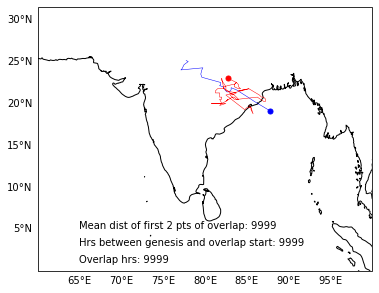

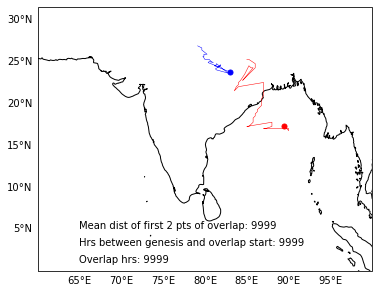

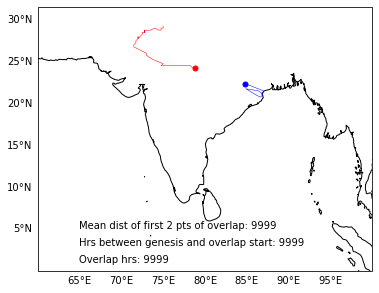

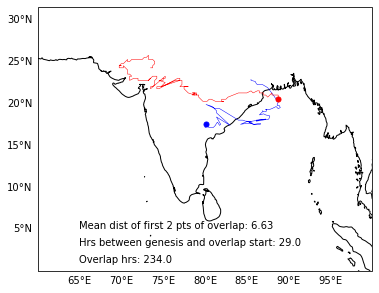

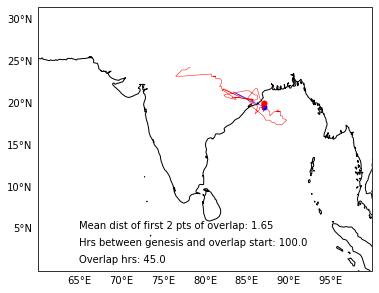

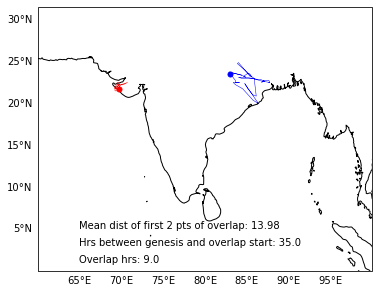

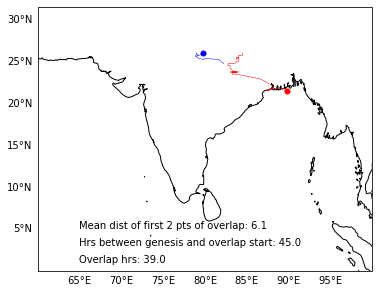

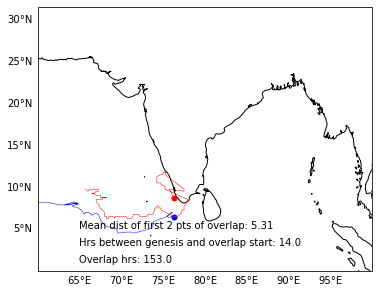

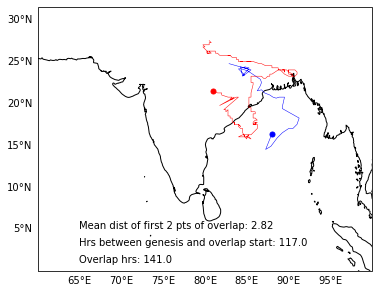

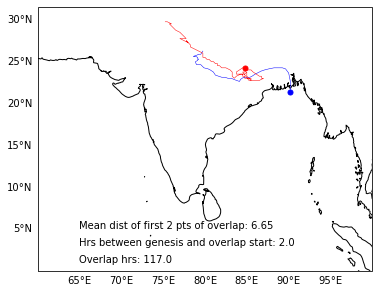

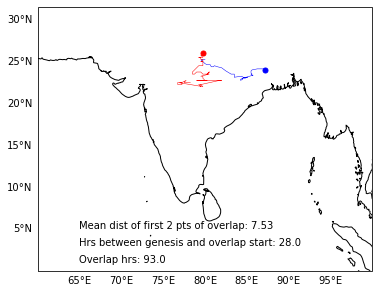

In [187]:
count = 0
for iitm_key, l in IITM_misses.items():
    era5_key, mean_dist, overlap_hrs, time_since_gen = l
    if 35 <= count <= 45:
        plot(all_IITM_tracks[iitm_key], ERA5[era5_key], round(mean_dist,2), overlap_hrs,
            time_since_gen)
    count += 1

In [148]:
IITM_misses

{'20070804-0-79.0-27.125': '20070803-8-89.75-19.5',
 '20070815-6-88.375-25.0': '20070809-22-90.25-18.75',
 '20070829-6-77.125-25.125': '20070823-21-82.25-18.5',
 '20090719-0-89.0-20.625': '20090711-11-86.0-24.0',
 '20090718-3-88.875-20.375': '20090717-7-71.25-22.25',
 '20090723-18-77.875-26.25': '20090717-7-71.25-22.25',
 '20090820-6-84.25-26.25': '20090814-14-83.75-24.0',
 '20090903-21-88.375-19.75': '20090830-19-84.5-17.5',
 '20090927-15-99.75-15.25': '20090925-22-87.5-16.25',
 '20100625-6-88.125-24.375': '20100616-3-72.25-19.75',
 '20100629-9-82.25-24.25': '20100623-6-87.75-21.0',
 '20100724-0-70.5-24.375': '20100723-22-88.0-21.5',
 '20100829-0-70.75-22.0': '20100828-14-75.75-20.5',
 '20100904-12-77.0-26.625': '20100828-14-75.75-20.5',
 '20100903-6-71.25-25.75': '20100902-3-86.75-17.75',
 '20100906-3-88.25-21.25': '20100902-3-86.75-17.75',
 '20100910-3-73.25-26.625': '20100902-3-86.75-17.75',
 '20100913-0-71.625-26.125': '20100912-22-83.25-14.75',
 '20100918-3-87.0-20.0': '20100912-

### read IITM

In [21]:
IITM = {}
ntotal_iitm = 0
nempty_iitm = 0
# IITM_multiple_hits = {}

column_names = [0, 'XGridCentre', 'YGridCentre', 'Longitude', 'Latitude', 
                    'MinSF', 'MinSLP', 'PressureDrop', 'MaxSfcWind', 'AvgRH', 'MaxSfcGeoPt', 'Year', 
                    'Month', 'Day', 'Hour']

# for outputfile in sorted(os.listdir('/global/cscratch1/sd/vishnus/GFS_IITM/2007_2018_newgp/')):

folderpath = '/global/homes/s/salilg/pandasNewCode/data/LPS_Tracks/Track_newgp/'
for outputfile in sorted(os.listdir(folderpath)):
    if outputfile.startswith('LPS_dslp_track_'):
        
        fileDate = outputfile[15:23]
        #all IITM file dates are observed date + 1; so moving back one day here
        date = changeIITMFileDate(fileDate)

        if date in common_files_to_read:

            if os.stat(folderpath + outputfile).st_size == 0:
                nempty_iitm += 1

            else:

                file = folderpath + outputfile

                possible_model_tracks = add_datetime_to_dic(
                    read_vishnu_csv_to_dic(file, column_names, 'IITM')
                                                )

                load_model_data(date, possible_model_tracks, IITM, ERA5, 'ERA5')

            ntotal_iitm += 1

            # get_num_multiple_hits(date, possible_model_tracks, ERA5, IITM_multiple_hits)#

In [22]:
len(IITM), nempty_iitm, ntotal_iitm

(103, 5, 135)

In [23]:
len(IITM),len(ECMWF)

(103, 117)

## Data wrangling for models (ECMWF and IITM)

In [39]:
# main things:
# for ECMWF and IITM, all tracks DO NOT need to start at 00 or 12 hours
# IITM: all tracks need to have 6-hourly frequency (to match ECMWF)

In [41]:
# UPDATE: NOT DOING THIS.
# make all ECMWF tracks start at 00 or 12 hours

# for key, df in ECMWF.items():
#     nearest_12 = ceil_dt(df['date'].iloc[0], timedelta(hours=12))
#     mask = df['date'] >= nearest_12
#     df = df.loc[mask]
    
#     ECMWF[key] = df

# UPDATE: NOT DOING THIS.
# make all IITM tracks start at 00 or 12 hours, and downsample from 3-hourly to 6-hourly data

# for key,df in IITM.items():
    
#     nearest_12 = ceil_dt(df['date'].iloc[0], timedelta(hours=12))
#     mask = df['date'] >= nearest_12

#     df = df.loc[mask]

In [24]:
# I also downsample IITM right before checking for hit, but don't make a permanent change, 
# so I make the downsampling permanent here.

for key,df in IITM.items():
    
    # using this mask instead of pd.df.asfreq('6h') because if the storm starts at an 03:00,
    #    .asfreq will make it 03:00, 09:00, 15:00, etc. instead of 06:00, 12:00, 18:00, etc.
    mask_downsample = (df['date'].dt.hour % 6 == 0) # downsample to 6-hourly
    df = df.loc[mask_downsample]

    IITM[key] = df

# Get ERA5, ECMWF, IITM systems corresponding to common model hits (skipped as we're not worrying about common hits)

In [90]:
ecmwf_era5_keys = [df['ERA5 key'].iloc[0] for key,df in ECMWF.items()]
iitm_era5_keys = [df['ERA5 key'].iloc[0] for key,df in IITM.items()]

# test overlap between hits in ECMWF and IITM
len([x for x in ecmwf_era5_keys if x in iitm_era5_keys])

76

In [44]:
len(ERA5)

160

In [21]:
# set(ecmwf_era5_keys) - set(iitm_era5_keys)

In [55]:
common_hits_era5_keys = [x for x in iitm_era5_keys if x in ecmwf_era5_keys]

In [56]:
ERA5_hits = {key: ERA5[key] for key in common_hits_era5_keys}

In [57]:
len(ERA5_hits)

69

In [58]:
ECMWF_common = {key: df for key,df in ECMWF.items() if df['ERA5 key'].iloc[0] in 
                common_hits_era5_keys}
IITM_common = {key: df for key,df in IITM.items() if df['ERA5 key'].iloc[0] in 
                common_hits_era5_keys}

In [63]:
ECMWF_common[list(ECMWF_common.keys())[0]]['ERA5 key'].iloc[0]

'20070618-10-89.25-14.25'

In [64]:
IITM_common[list(IITM_common.keys())[0]]['ERA5 key'].iloc[0]

'20070618-10-89.25-14.25'

In [88]:
len(ECMWF_common), len(IITM_common)

(90, 90)

In [56]:
ERA5_depressions = get_depressions(ERA5_hits)
ERA5_lows = get_lows(ERA5_hits)

In [57]:
len(ERA5_depressions), len(ERA5_lows)

(48, 42)

In [58]:
# overlap
ecmwf_dep = [df['ERA5 key'].iloc[0] for key,df in ECMWF_depressions.items()]
iitm_dep = [df['ERA5 key'].iloc[0] for key,df in IITM_depressions.items()]
era5_dep = list(ERA5_depressions.keys())

len([x for x in ecmwf_dep if x in era5_dep]), len([x for x in iitm_dep if x in era5_dep])

(34, 12)

In [59]:
# my work previously for dep vs. low was incorrect.
# Looked at Vishnu's script, I actually need to check pressure and wind speed simulatneously.
# for IITM, ['20090903', '20120907', '20180714'] were previously depressions, but are
#    no longer depressions.

# Get depressions and lows

In [25]:
# to be a depression, a track needs to have PressureDrop >= 4 hPa (i.e., 400 Pa)
#    and wind speed >= 8.5 m/s sustained for at least six hours continuously.

# code sourced from # https://stackoverflow.com/questions/56048650/tracking-3-day-streaks-
#when-a-condition-is-met-in-a-column-of-a-dataframe-withou

def is_depression(df, name_of_pressure_drop_column='PressureDrop',
                  name_of_wind_speed_column='MaxSfcWind'):
    
    # calculate how much time 1 data point represents, in hours
    hours_per_point = df['date'].diff().min().seconds / 3600
    
    # calculate how many points you'd need in order to sum to 6 hours
    num_points_needed = 6 / hours_per_point
    
    N = num_points_needed
    
    c1 = df[name_of_wind_speed_column].ge(8.5) & df[name_of_pressure_drop_column].ge(400)
    grouping = (c1 != c1.shift()).cumsum()

    df1 = df.assign(
        count = df.groupby(grouping)['date'].transform('count'),
        n = df.groupby(grouping).agg('cumcount'),
        grouping = grouping
    )

    c2 = df1['count'].ge(N)
    c3 = df1['n'].mod(N).eq(0) & df1['n'].le(df1['count']-N)

    df['flag'] = np.where(c1 & c2 & c3, 1, 0)
    
    return df['flag'].sum() > 0

def get_depressions(dic):
    # .copy() to avoid SettingWithCopyWarning
    return {key: df for key,df in dic.items() if is_depression(df.copy())}

def get_lows(dic):
    return {key: df for key,df in dic.items() if not is_depression(df.copy())}

In [26]:
# ECMWF_depressions = get_depressions(ECMWF_common)
# ECMWF_lows = get_lows(ECMWF_common)
ECMWF_depressions = get_depressions(ECMWF)
ECMWF_lows = get_lows(ECMWF)

In [27]:
len(ECMWF_depressions), len(ECMWF_lows)

(50, 67)

In [28]:
##### IITM_depressions = get_depressions(IITM_common)
# IITM_lows = get_lows(IITM_common)
IITM_depressions = get_depressions(IITM)
IITM_lows = get_lows(IITM)

In [29]:
len(IITM_depressions), len(IITM_lows)

(23, 80)

# get one MERRA2 track for every ERA5 track

In [30]:
big_merra2 = pd.concat([df for key,df in MERRA2.items()])

In [31]:
MERRA2_era5 = {}

for key,df in ERA5.items():
    
    overlap_mask = big_merra2['date'].isin(df['date'])
    overlap_merra2 = big_merra2[overlap_mask] # this composes all points in MERRA2 that overlap
    
    # if key == '20070623-20-69.0-20.5':
    #     print(overlap_merra2['MERRA2 key'].unique())
    
    if overlap_merra2.empty:
        print(key)
    
    for merra2_key in overlap_merra2['MERRA2 key'].unique():
        
        merra2_track = MERRA2[merra2_key]
        
        if check_for_hit(merra2_track, df):
            # if a previous ERA5 track was already tied to this MERRA2 track, then 
            #    we don't want to also tie this current ERA5 track to the same MERRA2 track
            #    (as likely the two ERA5 tracks are short and the MERRA2 track is long,
            #    and the second ERA5 track probably starts a while after the genesis of the MERRA2
            #    genesis).
            # In this case, we just compare the one long MERRA2 track with 
            #    the first ERA5 track, and the second ERA5 track then has no counterpart in MERRA2.
            # So, len(MERRA2_hits) will likely end up being a few less then len(ERA5_hits)
            if merra2_key in MERRA2_era5: 
                continue
            else:
                merra2_df = merra2_track
                merra2_df['ERA5 key'] = pd.Series(key, index=merra2_df.index)
                MERRA2_era5[merra2_key] = merra2_df
                break
            
        
#         # this is only points in the specific MERRA2 track that overlap
#         overlap_of_merra2_track = merra2_track[merra2_track['date'].isin(df['date'])] 
        
#         diff_merra2 = (overlap_of_merra2_track['date'].iloc[-1] - 
#                        overlap_of_merra2_track['date'].iloc[0])
#         overlap_in_hours_of_merra2 = diff_merra2.total_seconds() / 3600
        
#         overlap_of_era5_track = df[df['date'].isin(overlap_of_merra2_track['date'])]
        
#         mean_distance = get_mean_distance(overlap_of_era5_track, overlap_of_merra2_track)
        
#         # if key == '20140903-1-74.0-25.0':
#         #     print(overlap_in_hours_of_merra2, mean_distance, merra2_key)
#         #     print(merra2_key in MERRA2_hits)
        
#         if overlap_in_hours_of_merra2 >= 24 and mean_distance <= 5:
#             # if a previous ERA5 track was already tied to this MERRA2 track, then 
#             #    we don't want to also tie this current ERA5 track to the same MERRA2 track
#             #    (as likely the two ERA5 tracks are short and the MERRA2 track is long,
#             #    and the second ERA5 track probably starts a while after the genesis of the MERRA2
#             #    genesis).
#             # In this case, we just compare the one long MERRA2 track with 
#             #    the first ERA5 track, and the second ERA5 track then has no counterpart in MERRA2.
#             # So, len(MERRA2_hits) will likely end up being a few less then len(ERA5_hits)
#             if merra2_key in MERRA2_era5: 
#                 continue
#             else:
#                 merra2_df = merra2_track
#                 merra2_df['ERA5 key'] = pd.Series(key, index=merra2_df.index)
#                 MERRA2_era5[merra2_key] = merra2_df
#                 break

20130602-10-93.0-14.5
20150928-17-77.25-9.5


In [32]:
len(MERRA2_era5)

138

In [34]:
# suhas wanted this info
# suhas_merra2_era5 = {key: df['ERA5 key'].iloc[0] for key,df in MERRA2_era5.items()}
# pickle_out = open('suhas_merra2_era5_keys.pickle', 'wb')
# pickle.dump(suhas_merra2_era5, pickle_out)
# pickle_out.close()

In [46]:
# 141 MERRA2 tracks that were matched with an ERA5 track. So 19 ERA5 tracks that we couldn't 
#    find a match for...
merra2_keys_with_era5_keys = [df['ERA5 key'].iloc[0] for key,df in MERRA2_era5.items()]
set(ERA5.keys()) - set(merra2_keys_with_era5_keys)

{'20070617-14-64.25-19.25',
 '20080617-18-79.25-26.75',
 '20080628-20-81.25-25.0',
 '20080705-1-82.5-26.0',
 '20090717-7-71.25-22.25',
 '20100828-14-75.75-20.5',
 '20100907-12-82.0-20.5',
 '20110607-4-89.5-18.75',
 '20110811-10-88.25-22.25',
 '20110818-10-84.0-25.75',
 '20130602-10-93.0-14.5',
 '20130610-10-64.5-22.0',
 '20140731-7-69.75-21.75',
 '20140903-1-74.0-25.0',
 '20150911-2-86.0-17.25',
 '20150928-17-77.25-9.5',
 '20160625-19-68.0-22.0',
 '20170623-10-91.0-20.5',
 '20170715-2-72.0-23.75'}

## Create dictionaries that all have the same keys

In [33]:
def change_keys(dic, key_desired):
    return {df[key_desired].iloc[0]: df for key,df in dic.items()}

# temporary
ECMWF_with_era5_keys = change_keys(ECMWF, 'ERA5 key')
IITM_with_era5_keys = change_keys(IITM, 'ERA5 key')

# MERRA2_era5 is a dictionary of the MERRA2 tracks that have been matched with an ERA5 track
MERRA2_with_era5_keys = change_keys(MERRA2_era5, 'ERA5 key')

# make dictionaries for ERA5 containing only the tracks that overlap with ECMWF and IITM
ERA5_overlap_ecmwf = {key: df for key,df in ERA5.items() if key in ECMWF_with_era5_keys.keys()}
ERA5_overlap_iitm = {key: df for key,df in ERA5.items() if key in IITM_with_era5_keys.keys()}

# make dictionaries for MERRA2 containing only the tracks that overlap with ECMWF and IITM
MERRA2_overlap_ecmwf = {key: df for key,df in MERRA2_with_era5_keys.items() 
                if key in ECMWF_with_era5_keys.keys()}
MERRA2_overlap_iitm = {key: df for key,df in MERRA2_with_era5_keys.items() 
               if key in IITM_with_era5_keys.keys()}

In [45]:
# find number of common matches between ECMWF and IITM
len([x for x in ECMWF_with_era5_keys if x in IITM_with_era5_keys])

91

In [34]:
len(ECMWF_with_era5_keys), len(IITM_with_era5_keys), len(ERA5_overlap_ecmwf), len(ERA5_overlap_iitm)                                                        

(117, 103, 117, 103)

In [35]:
len(MERRA2_with_era5_keys), len(MERRA2_overlap_ecmwf), len(MERRA2_overlap_iitm)

(138, 103, 94)

In [36]:
# MERRA2_with_era5_keys = change_keys(MERRA2_hits, 'ERA5 key')
# ECMWF_with_era5_keys = change_keys(ECMWF_common, 'ERA5 key')
# IITM_with_era5_keys = change_keys(IITM_common, 'ERA5 key')

In [37]:
# change keys for depressions and lows
# these are only for statistics here; for the deps/lows analyses later, we only look at ERA5 tracks

ECMWF_depressions_with_era5_keys = change_keys(ECMWF_depressions, 'ERA5 key')
ECMWF_lows_with_era5_keys = change_keys(ECMWF_lows, 'ERA5 key')

IITM_depressions_with_era5_keys = change_keys(IITM_depressions, 'ERA5 key')
IITM_lows_with_era5_keys = change_keys(IITM_lows, 'ERA5 key')

MERRA2_depressions_with_era5_keys = change_keys(get_depressions(MERRA2_era5), 'ERA5 key')
MERRA2_lows_with_era5_keys = change_keys(get_lows(MERRA2_era5), 'ERA5 key')

In [38]:
len(MERRA2_depressions_with_era5_keys), len(MERRA2_lows_with_era5_keys)

(83, 55)

In [39]:
ERA5_depressions_ecmwf = get_depressions(ERA5_overlap_ecmwf)
ERA5_lows_ecmwf = get_lows(ERA5_overlap_ecmwf)
ERA5_depressions_iitm = get_depressions(ERA5_overlap_iitm)
ERA5_lows_iitm = get_lows(ERA5_overlap_iitm)

In [40]:
len(ERA5_depressions_ecmwf), len(ERA5_lows_ecmwf) # adds to 117

(56, 61)

In [54]:
print(len(list(set(ERA5_depressions_ecmwf).intersection(ECMWF_depressions_with_era5_keys))))
print(len(list(set(ERA5_lows_ecmwf).intersection(ECMWF_lows_with_era5_keys))))

38
49


In [55]:
len(ERA5_depressions_iitm), len(ERA5_lows_iitm) # adds to 103

(52, 51)

In [56]:
print(len(list(set(ERA5_depressions_iitm).intersection(IITM_depressions_with_era5_keys))))
print(len(list(set(ERA5_lows_iitm).intersection(IITM_lows_with_era5_keys))))

13
41


In [42]:
ERA5_135 = {key: df for key,df in ERA5.items() if key[:8] in common_files_to_read}

In [43]:
len(ERA5_135) # 137 because the two dates in ERA5 that each had 2 tracks on the same day

137

In [46]:
len(get_depressions(ERA5_135)), len(get_lows(ERA5_135))

(60, 77)

In [50]:
MERRA2_for_ERA5_135 = {key: df for key,df in MERRA2_with_era5_keys.items() if key in ERA5_135}
len(MERRA2_for_ERA5_135)

118

In [52]:
len(get_depressions(MERRA2_for_ERA5_135)), len(get_lows(MERRA2_for_ERA5_135))

(70, 48)

## Store data

In [62]:
import pickle

In [63]:
def store_as_pickle(data, filepath):
    pickle_out = open(filepath, 'wb')
    pickle.dump(data, pickle_out)
    pickle_out.close()

In [65]:
# temporary
store_as_pickle(ERA5_135, 'data/update/era5.pickle') # needed for genesis/lysis plots

store_as_pickle(ECMWF_with_era5_keys, 'data/update/ecmwf.pickle')
store_as_pickle(IITM_with_era5_keys, 'data/update/iitm.pickle')

store_as_pickle(ERA5_overlap_ecmwf, 'data/update/era5_ecmwf.pickle')
store_as_pickle(ERA5_overlap_iitm, 'data/update/era5_iitm.pickle')
# the above two will replace the old era5.pickle

store_as_pickle(MERRA2_for_ERA5_135, 'data/update/merra2.pickle') # maybe for genesis/lysis
store_as_pickle(MERRA2_overlap_ecmwf, 'data/update/merra2_ecmwf.pickle')
store_as_pickle(MERRA2_overlap_iitm, 'data/update/merra2_iitm.pickle')

l = [ERA5_depressions_ecmwf,
     ERA5_lows_ecmwf,
     ERA5_depressions_iitm,
     ERA5_lows_iitm]

store_as_pickle(l, 'data/update/depressions_lows.pickle')

Don't run `store_pickle` calls below this.

In [106]:
store_as_pickle(ERA5_hits, 'data/update/era5.pickle')

In [107]:
store_as_pickle(ECMWF_with_era5_keys, 'data/update/ecmwf.pickle')

In [108]:
store_as_pickle(IITM_with_era5_keys, 'data/update/iitm.pickle')

In [109]:
store_as_pickle(MERRA2_with_era5_keys, 'data/update/merra2.pickle')

In [110]:
l = [ECMWF_depressions_with_era5_keys,
     ECMWF_lows_with_era5_keys,
     IITM_depressions_with_era5_keys,
     IITM_lows_with_era5_keys,
     ERA5_depressions,
     ERA5_lows,
     MERRA2_depressions_with_era5_keys,
     MERRA2_lows_with_era5_keys]

store_as_pickle(l, "data/update/depressions_lows.pickle")

In [108]:
# pickle_out = open("data/merra2.pickle", 'wb')
# pickle.dump(MERRA2, pickle_out)
# pickle_out.close()

In [38]:
# pickle_out = open("data/era5.pickle", 'wb')
# pickle.dump(ERA5_common, pickle_out)
# pickle_out.close()

In [170]:
# pickle_out = open("data/ecmwf.pickle", 'wb')
# pickle.dump(ECMWF_hits, pickle_out)
# pickle_out.close()

In [171]:
# pickle_out = open("data/iitm.pickle", 'wb')
# pickle.dump(IITM_hits, pickle_out)
# pickle_out.close()

In [111]:
# pickle_out = open("data/depressions_lows.pickle", 'wb')
# pickle.dump([ECMWF_depressions, ECMWF_lows, IITM_depressions, IITM_lows,
#             ERA5_depressions, ERA5_lows], pickle_out)
# pickle_out.close()

## Checking data

In [54]:
# min gap between points for each storm for:
#    MERRA2 should be 3 hours
#    ERA5 should be 1 hour

df = MERRA2

for key in df:
    if df[key]['date'].diff().min().seconds // 3600 != 3:
        print('oh no')

In [68]:
# min gap between points for each storm for:
#    ECMWF should be 6 hours
#    IITM should be 3 hours

df = IITM

for storm in df:
    for track in df[storm]:
        if df[storm][track]['date'].diff().min().seconds // 3600 != 3:
            print('oh no')

# Appendix

In [103]:
# USELESS FUNCTION, WILL DELETE SOON

# this function takes in the lines of a tab delimited file and reads them into a pandas dataframe.

def read_lines_to_df(file, lines, dic, col_names, usecols, key=None, observation=False):
    
    # for the start_line_locations dictionary:
    # keys are the indices in the LPS_track_yyyymmdd.txt file at which a new storm starts
    #    (i.e., the index at which there's a line of the form "start 20 2007 06 17 12"
    # values are the number of rows that follow this start line, that are part of the same 
    #    storm (also given by the second element in the start line. In the case above, it's 20)

    # example: start_line_locations = {0: 41, 42: 20}, meaning that there's a 'start' line at 
    #    index 0 that's followed by 41 lines (not including itself), and then the next 
    #    'start' line is at index 42, followed by 20 lines (not including itself).
    start_line_locations = {} 

    for index, line in enumerate(lines):
        linesplit = line.strip().split('\t')
        if linesplit[0] == 'start':
            num_rows = int(linesplit[1])
            start_line_locations[index] = num_rows
    
    # the observation (ERA5) file, LPS_track_India_1979_2019_JJS.txt, is set up differently than
    #    the LPS_track_yyyymmdd.txt files. The latter have several tracks for one storm in the file;
    #    the former has one track per storm, and all of these tracks in the same file.
    if observation==True:
        
        for elem in start_line_locations:
            index_of_storm_start = elem
            num_rows_of_storm = start_line_locations[elem]
            key = "".join([x.zfill(2) for x in lines[index_of_storm_start].strip().split('\t')[2:5]])
            
            dic[key] = [] # initialize the list

            df = pd.read_csv(file, header = None, sep = '\t',
                             skiprows = index_of_storm_start + 1,
                             nrows = num_rows_of_storm,
                             usecols=usecols, # the first element is a tab
                             names = col_names)

            dic[key].append(df)
        
    else: # observation==False
        
        if not key:
            raise ArgumentError('please input a key, as you are not working with ERA5')
        
        # for the models, the key has to be supplied separately and we cannot just use the start
        #    date of the track as the key. This is because the start date of an arbitrary track
        #    might be, say, 5 days after the observed genesis, but we want the key to match the
        #    date of observed genesis so that we can identify the storm.
        
        dic[key] = [] #initialize the list

        for elem in start_line_locations:
            index_of_storm_start = elem
            num_rows_of_storm = start_line_locations[elem]

            df = pd.read_csv(file, header = None, sep = '\t',
                             skiprows = index_of_storm_start + 1,
                             nrows = num_rows_of_storm,
                             usecols=usecols, # the first element is a tab
                             names = col_names)

            dic[key].append(df)
        
    return dic

In [9]:
# OLD, JUST FOR REFERENCE

MERRA2_storms = {}
col_names = ['longitude', 
             'latitude', 
             'Pressure Drop (Pa)', #  (otherwise closed contour in Pa)
             'Maximum Surface Wind (m/s)', #  within 3 degrees
             'year',
             'month',
             'day',
             'hour']
usecols=[3, 4, 6, 7, 16, 17, 18, 19]

# read_lines_to_df(file, lines, dic, col_names, usecols, key=None, observation=False):
MERRA2_storms = read_lines_to_df(fileo, lineso, MERRA2_storms, col_names, usecols, observation=True)

# ensure lons are in -180 to +180 format
df_tmp['Lon'][df_tmp['Lon'] > 180] -= 360

In [183]:
import cartopy.crs as ccrs

# plot IITM vs. ERA5
def plot(df1, df2, mean_dist, overlap_hrs, time_since_gen):
    fig = plt.figure(figsize=[6, 6])

    # create map
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([60, 100, 0, 30])
    #ax.stock_img()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines =False

    plt.plot(df1['Longitude'].iloc[0], df1['Latitude'].iloc[0], color='b', marker='.', markersize=10,
                     transform=ccrs.Geodetic())
    plt.plot(df1['Longitude'], df1['Latitude'], color='b', linewidth=0.5,linestyle='solid',
                     transform=ccrs.Geodetic())
    
    plt.annotate('Mean dist of first 2 pts of overlap: ' + str(mean_dist), xy=(65, 5), xycoords='data',
                    xytext=(65, 5), textcoords='data')
    plt.annotate('Hrs between genesis and overlap start: ' + str(time_since_gen), xy=(65, 3), xycoords='data',
                    xytext=(65, 3), textcoords='data')
    plt.annotate('Overlap hrs: ' + str(overlap_hrs), xy=(65, 1), xycoords='data',
                    xytext=(65, 1), textcoords='data')
    
    # plt.annotate('ECMWF genesis: ' + str(df1['date'].iloc[0]), xy=(65, 7), xycoords='data',
    #                 xytext=(65, 7), textcoords='data')
    # plt.annotate('ECMWF end: ' + str(df1['date'].iloc[-1]), xy=(65, 5), xycoords='data',
    #                 xytext=(65, 5), textcoords='data')
    
    
    plt.plot(df2['Longitude'].iloc[0], df2['Latitude'].iloc[0], color='r', marker='.', markersize=10,
                     transform=ccrs.Geodetic())
    plt.plot(df2['Longitude'], df2['Latitude'], color='r', linewidth=0.5,linestyle='solid',
                     transform=ccrs.Geodetic())
    # plt.annotate('ERA5 genesis: ' + str(df2['date'].iloc[0]), xy=(65, 3), xycoords='data',
    #                 xytext=(65, 3), textcoords='data')
    # plt.annotate('ERA5 end: ' + str(df1['date'].iloc[-1]), xy=(65, 1), xycoords='data',
    #                 xytext=(65, 1), textcoords='data')

In [11]:
# the 20150918 system in IITM has 2 tracks, both starting at the exact same time,
#    both of whom have the same number of lines. The first one is a hit and the second one is not;
#    hence, the first one was getting deleted because of the duplicated key.
# So, below, I'm manually inserting the first track in place of the second one.

# column_names = [0, 'XGridCentre', 'YGridCentre', 'Longitude', 'Latitude', 
#                     'MinSF', 'MinSLP', 'PressureDrop', 'MaxSfcWind', 'AvgRH', 'MaxSfcGeoPt', 'Year', 
#                     'Month', 'Day', 'Hour']

# file = '/global/cscratch1/sd/vishnus/GFS_IITM/2007_2018_newgp/LPS_dslp_track_20150919_newgp.txt'
# df = pd.read_csv(file, header=None, names=column_names, sep='\t')
# groups = df[0].isin(['start']).cumsum()
# relevant_df = df.groupby(groups).get_group(1)
# IITM['20150918'] = add_datetime_to_dic(
#                         {"-".join([str(int(x)).zfill(2) for x in list(relevant_df.iloc[0][1:6])]):
#                         relevant_df.iloc[1:, 1:]}
#                     )

In [98]:
# takes a given timestamp and adds delta to it

def ceil_dt(dt, delta):
    dt = dt.to_pydatetime()
    return dt + (datetime.min - dt) % delta

In [99]:
# this was used in the old implementation of check_for_hit, looks like it's no longer 
#    being used.

# if a df with a timeseries is a missing a timestamp_desired, this function will
#    interpolate it.
# Not well vectorized, need to write cleaner code for this if it ends up having runtime issues.

def interpolate(timestamp_desired, df):
    
    if timestamp_desired > df['date'].iloc[-1]: # if model starts after obs ends
        return 0, 0
        
    if timestamp_desired < df['date'].iloc[0]:
        return 0, 0

    # get row for the last observation point right before model genesis
    mask_prev = (df['date'] < timestamp_desired)
    prev = df.loc[mask_prev].iloc[-1] # get last row of masked pre-point df
    prev_lon, prev_lat, prev_time = prev['Longitude'], prev['Latitude'], prev['date']

    mask_after = (df['date'] > timestamp_desired)
    after = df.loc[mask_after].iloc[0] # get first row of masked post-point df
    after_lon, after_lat, after_time = after['Longitude'], after['Latitude'], after['date']

    # get interpolated value
    diff_prev = (timestamp_desired - prev_time).seconds/3600
    diff_after = (after_time - timestamp_desired).seconds/3600

    weighted_lon = (((diff_after * prev_lon) + (diff_prev * after_lon)) 
                        / (diff_prev + diff_after)
                   )
    weighted_lat = (((diff_after * prev_lat) + (diff_prev * after_lat)) 
                        / (diff_prev + diff_after)
                   )

    lon, lat = weighted_lon, weighted_lat
    
    return lon, lat

In [92]:
# given a model and observation, check whether the model is a hit
# a model is defined to be a 'hit' if it has a point, within the first 24 hours of its genesis,
#    that is inside a 5-degree radius of the observed track at that time.

def check_for_hit_old(model, obs):
    
    genesis_date_model = model['date'].iloc[0]
    for index,row in model.iterrows():
        if row['date'] < genesis_date_model + timedelta(hours=24):
            
            time_model = row['date']
            location_model = row[['Longitude', 'Latitude']]
            model_lon, model_lat = location_model['Longitude'], location_model['Latitude']

            corresponding_obs_row = obs.loc[obs['date']==time_model]

            location_obs = corresponding_obs_row[['Longitude', 'Latitude']]
            obs_lon, obs_lat = location_obs['Longitude'], location_obs['Latitude']

            if location_obs.shape[0] == 0: # if the observation is missing data at that point:
                # need to interpolate
                obs_lon, obs_lat = interpolate(time_model, obs)

            if (math.sqrt( (model_lon-obs_lon)**2 + (model_lat-obs_lat)**2 ) <= 5):
                return True
    return False